<a href="https://colab.research.google.com/github/umangSharmacs/Charles_research_codes/blob/main/ami_corpus_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing important libraries 

In [ ]:
import nltk
from nltk.corpus import stopwords
import csv
from nltk.tag import pos_tag # for proper noun
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import math
from nltk.stem import PorterStemmer
import re
import pytrends
from pytrends.request import TrendReq
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tag import DefaultTagger
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import spatial
from statistics import median

import scipy.stats
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from bert_serving.client import BertClient

import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

from IPython.display import clear_output

In [ ]:
def preprocess(text):
    
    sent_tokens = nltk.sent_tokenize(text)
   
    word_tokens = nltk.word_tokenize(text)
    word_tokens_lower=[word.lower() for word in word_tokens]
    
    stopWords = list(set(stopwords.words("english")))
    word_tokens_refined=[x for x in word_tokens_lower if x not in stopWords]
    #print(len(word_tokens_refined))
    
    stem = []
    ps = PorterStemmer()
    for w in word_tokens_refined:
        stem.append(ps.stem(w))
    word_tokens_refined=stem    
    return text,sent_tokens,word_tokens,word_tokens_lower,word_tokens_refined



In [ ]:
path='C:\\Users\\umang\\Desktop\\Research\\AMICorpusXML-master\\AMICorpusXML-master\\data\\ami-transcripts'
filelist=os.listdir(path)
transcripts={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        transcripts[file.split('.')[0]]=txt

path='C:\\Users\\umang\\Desktop\\Research\\AMICorpusXML-master\\AMICorpusXML-master\\data\\ami-summary\\extractive'
filelist=os.listdir(path)       
extractive_summary={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        extractive_summary[file.split('.')[0]]=txt 
        
path='C:\\Users\\umang\\Desktop\\Research\\AMICorpusXML-master\\AMICorpusXML-master\\data\\ami-summary\\abstractive'
filelist=os.listdir(path)       
abstractive_summary={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        abstractive_summary[file.split('.')[0]]=txt



In [ ]:
print(len(transcripts),len(abstractive_summary),len(extractive_summary))

171 142 137


Only takes those texts which already have <b>both</b> the summaries

In [ ]:
l=list(transcripts.keys())

for i in l:
    if i not in abstractive_summary:
        del transcripts[i]
        if i in extractive_summary:
            del extractive_summary[i]
        continue
    if i not in extractive_summary:
        del transcripts[i]
        if i in abstractive_summary:
            del abstractive_summary[i]

In [ ]:
print(len(transcripts),len(abstractive_summary),len(extractive_summary))

137 137 137


## Preprocessing the transcripts into sentence tokens, word tokens and refined word tokens 

In [ ]:
sentence_tokens={}
word_tokens={}
refined_words={}
for i in transcripts.keys():
    t=preprocess(transcripts[i])
    sentence_tokens[i]=t[1]
    word_tokens[i]=t[2]
    refined_words[i]=t[-1]

In [ ]:
df=pd.DataFrame(index=list(transcripts.keys()))
df['Sentences']=list(transcripts.values())
df['abstractive_summary']=list(abstractive_summary.values())
df['extractive_summary']=list(extractive_summary.values())
df['sentence_tokens']=(sentence_tokens.values())
df['word_tokens']=list(word_tokens.values())
df['refined_words']=list(refined_words.values())

C:\Users\umang\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Preprocessing the summaries into sentence tokens, word tokens and refined word tokens 

In [ ]:
extractive_summ_sentence_tokens={}
extractive_summ_word_tokens={}
extractive_summ_refined_words={}
for i in extractive_summary.keys():
    t=preprocess(extractive_summary[i])
    extractive_summ_sentence_tokens[i]=t[1]
    extractive_summ_word_tokens[i]=t[2]
    extractive_summ_refined_words[i]=t[-1]
    
for i in extractive_summ_sentence_tokens.keys():
    for index,sentence in enumerate(extractive_summ_sentence_tokens[i]):
        if len(sentence)>=2 and sentence[-2]==' ':
            t=sentence.split(' ')
            t1=''.join(t[-2:])
            t.pop()
            t.pop()
            t.append(t1)
            extractive_summ_sentence_tokens[i][index]=' '.join(t)
    

abstractive_summ_sentence_tokens={}
abstractive_summ_word_tokens={}
abstractive_summ_refined_words={}
for i in abstractive_summary.keys():
    t=preprocess(abstractive_summary[i])
    abstractive_summ_sentence_tokens[i]=t[1]
    abstractive_summ_word_tokens[i]=t[2]
    abstractive_summ_refined_words[i]=t[-1]

for i in abstractive_summ_sentence_tokens.keys():
    for index,sentence in enumerate(abstractive_summ_sentence_tokens[i]):
        if len(sentence)>=2 and sentence[-2]==' ':
            t=sentence.split(' ')
            t1=''.join(t[-2:])
            t.pop()
            t.pop()
            t.append(t1)
            abstractive_summ_sentence_tokens[i][index]=' '.join(t)

df['extractive_summ_sentence_tokens']=list(extractive_summ_sentence_tokens.values())
df['extractive_summ_word_tokens']=list(extractive_summ_word_tokens.values())
df['extractive_summ_refined_words']=list(extractive_summ_refined_words.values())

df['abstractive_summ_sentence_tokens']=list(abstractive_summ_sentence_tokens.values())
df['abstractive_summ_word_tokens']=list(abstractive_summ_word_tokens.values())
df['abstractive_summ_refined_words']=list(abstractive_summ_refined_words.values())

In [ ]:
df.head()

,Sentences,abstractive_summary,extractive_summary,sentence_tokens,word_tokens,refined_words,extractive_summ_sentence_tokens,extractive_summ_word_tokens,extractive_summ_refined_words,abstractive_summ_sentence_tokens,abstractive_summ_word_tokens,abstractive_summ_refined_words
ES2002a,Um I'm Craig and I'm User Interface. Yeah. Wel...,The project manager introduced the upcoming pr...,Um well this is the kick-off meeting for our o...,"[Um I'm Craig and I'm User Interface., Yeah., ...","[Um, I, 'm, Craig, and, I, 'm, User, Interface...","[um, 'm, craig, 'm, user, interfac, ., yeah, ....",[Um well this is the kick-off meeting for our ...,"[Um, well, this, is, the, kick-off, meeting, f...","[um, well, kick-off, meet, project, ., 're, de...",[The project manager introduced the upcoming p...,"[The, project, manager, introduced, the, upcom...","[project, manag, introduc, upcom, project, tea..."
ES2002b,"Mm yeah. Nope, we're all set. Which which is t...",The project manager briefed the team on some n...,"Okay , we've got half an hour for this one um ...","[Mm yeah., Nope, we're all set., Which which i...","[Mm, yeah, ., Nope, ,, we, 're, all, set, ., W...","[mm, yeah, ., nope, ,, 're, set, ., clunki, on...","[Okay , we've got half an hour for this one um...","[Okay, ,, we, 've, got, half, an, hour, for, t...","[okay, ,, 've, got, half, hour, one, um, uh, d...",[The project manager briefed the team on some ...,"[The, project, manager, briefed, the, team, on...","[project, manag, brief, team, new, requir, con..."
ES2002c,"Yeah. Yeah, sure. It kinda does make sense, do...",The project manager recapped the decisions mad...,I'll just just recap on the minutes from the l...,"[Yeah., Yeah, sure., It kinda does make sense,...","[Yeah, ., Yeah, ,, sure, ., It, kinda, does, m...","[yeah, ., yeah, ,, sure, ., kinda, make, sens,...",[I'll just just recap on the minutes from the ...,"[I, 'll, just, just, recap, on, the, minutes, ...","['ll, recap, minut, last, meet, ., decid, targ...",[The project manager recapped the decisions ma...,"[The, project, manager, recapped, the, decisio...","[project, manag, recap, decis, made, previou, ..."
ES2002d,"No. Ninja Homer, made in Japan. And there isn'...",The project manager recapped the decisions mad...,Well this is the uh final detailed design meet...,"[No., Ninja Homer, made in Japan., And there i...","[No, ., Ninja, Homer, ,, made, in, Japan, ., A...","[., ninja, homer, ,, made, japan, ., n't, uh, ...",[Well this is the uh final detailed design mee...,"[Well, this, is, the, uh, final, detailed, des...","[well, uh, final, detail, design, meet, ., um,...",[The project manager recapped the decisions ma...,"[The, project, manager, recapped, the, decisio...","[project, manag, recap, decis, made, previou, ..."
ES2003a,"Okay, well I think we're ready to begin. Right...",The team members introduced themselves to each...,"my name's Adam Duguid , Ebenezer Ademesoye . I...","[Okay, well I think we're ready to begin., Rig...","[Okay, ,, well, I, think, we, 're, ready, to, ...","[okay, ,, well, think, 're, readi, begin, ., r...","[my name's Adam Duguid , Ebenezer Ademesoye., ...","[my, name, 's, Adam, Duguid, ,, Ebenezer, Adem...","[name, 's, adam, duguid, ,, ebenez, ademesoy, ...",[The team members introduced themselves to eac...,"[The, team, members, introduced, themselves, t...","[team, member, introduc, name, role, project, ..."


### Average sentence length of transcript  

In [ ]:
average=[]
for i in df['sentence_tokens']:
    total=0
    for sentence in i:
        total+=len(sentence.split(' '))
    avg=total/len(i)
    average.append(avg)
df['average_sentence_length']=average

### Average word length of transcripts 

In [ ]:
average=[]
for i in df['word_tokens']:
    total=0
    for word in i:
        total+=len(word)
    avg=total/len(i)
    average.append(avg)
df['average_word_length']=average

### Maximum five words of each transcript  (Work to be done) 

In [ ]:
max_five=[]
for index,words in enumerate(df.refined_words):
    dic={}
    for word in words:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1
    #print((sorted(dic, key=dic.get, reverse=True)))
    max_five.append(sorted(dic, key=dic.get, reverse=True)[:25])
df['max_five']=max_five

In [ ]:
df.head()

,Sentences,abstractive_summary,extractive_summary,sentence_tokens,word_tokens,refined_words,extractive_summ_sentence_tokens,extractive_summ_word_tokens,extractive_summ_refined_words,abstractive_summ_sentence_tokens,abstractive_summ_word_tokens,abstractive_summ_refined_words,average_sentence_length,average_word_length,max_five
ES2002a,Um I'm Craig and I'm User Interface. Yeah. Wel...,The project manager introduced the upcoming pr...,Um well this is the kick-off meeting for our o...,"[Um I'm Craig and I'm User Interface., Yeah., ...","[Um, I, 'm, Craig, and, I, 'm, User, Interface...","[um, 'm, craig, 'm, user, interfac, ., yeah, ....",[Um well this is the kick-off meeting for our ...,"[Um, well, this, is, the, kick-off, meeting, f...","[um, well, kick-off, meet, project, ., 're, de...",[The project manager introduced the upcoming p...,"[The, project, manager, introduced, the, upcom...","[project, manag, introduc, upcom, project, tea...",7.831325,3.417464,"[., ,, um, yeah, 's, like, okay, ?, uh, know, ..."
ES2002b,"Mm yeah. Nope, we're all set. Which which is t...",The project manager briefed the team on some n...,"Okay , we've got half an hour for this one um ...","[Mm yeah., Nope, we're all set., Which which i...","[Mm, yeah, ., Nope, ,, we, 're, all, set, ., W...","[mm, yeah, ., nope, ,, 're, set, ., clunki, on...","[Okay , we've got half an hour for this one um...","[Okay, ,, we, 've, got, half, an, hour, for, t...","[okay, ,, 've, got, half, hour, one, um, uh, d...",[The project manager briefed the team on some ...,"[The, project, manager, briefed, the, team, on...","[project, manag, brief, team, new, requir, con...",10.118669,3.473104,"[., ,, um, okay, 's, yeah, like, ?, think, mm-..."
ES2002c,"Yeah. Yeah, sure. It kinda does make sense, do...",The project manager recapped the decisions mad...,I'll just just recap on the minutes from the l...,"[Yeah., Yeah, sure., It kinda does make sense,...","[Yeah, ., Yeah, ,, sure, ., It, kinda, does, m...","[yeah, ., yeah, ,, sure, ., kinda, make, sens,...",[I'll just just recap on the minutes from the ...,"[I, 'll, just, just, recap, on, the, minutes, ...","['ll, recap, minut, last, meet, ., decid, targ...",[The project manager recapped the decisions ma...,"[The, project, manager, recapped, the, decisio...","[project, manag, recap, decis, made, previou, ...",12.281201,3.503235,"[., ,, um, yeah, 's, like, okay, think, ?, thi..."
ES2002d,"No. Ninja Homer, made in Japan. And there isn'...",The project manager recapped the decisions mad...,Well this is the uh final detailed design meet...,"[No., Ninja Homer, made in Japan., And there i...","[No, ., Ninja, Homer, ,, made, in, Japan, ., A...","[., ninja, homer, ,, made, japan, ., n't, uh, ...",[Well this is the uh final detailed design mee...,"[Well, this, is, the, uh, final, detailed, des...","[well, uh, final, detail, design, meet, ., um,...",[The project manager recapped the decisions ma...,"[The, project, manager, recapped, the, decisio...","[project, manag, recap, decis, made, previou, ...",9.031579,3.421855,"[., ,, yeah, um, okay, 's, ?, think, mm-hmm, l..."
ES2003a,"Okay, well I think we're ready to begin. Right...",The team members introduced themselves to each...,"my name's Adam Duguid , Ebenezer Ademesoye . I...","[Okay, well I think we're ready to begin., Rig...","[Okay, ,, well, I, think, we, 're, ready, to, ...","[okay, ,, well, think, 're, readi, begin, ., r...","[my name's Adam Duguid , Ebenezer Ademesoye., ...","[my, name, 's, Adam, Duguid, ,, Ebenezer, Adem...","[name, 's, adam, duguid, ,, ebenez, ademesoy, ...",[The team members introduced themselves to eac...,"[The, team, members, introduced, themselves, t...","[team, member, introduc, name, role, project, ...",12.811321,3.503226,"[,, ., um, uh, 's, 're, okay, ?, one, well, ye..."


### Maximum, minimum sentences, their positions and their length of transcripts 

In [ ]:
max_len_list=[]
min_len_list=[]
max_sentence=[]
min_sentence=[]
max_sentence_position=[]
min_sentence_position=[]
for sentences in df.sentence_tokens:
    minimum=min([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    maximum=max([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    min_sentence.append(sentences[minimum[1]])
    max_sentence.append(sentences[maximum[1]])
    min_len_list.append(minimum[0])
    max_len_list.append(maximum[0])
    min_sentence_position.append((minimum[1]+1)/len(sentences))
    max_sentence_position.append((maximum[1]+1)/len(sentences))
df['max_sentence_length']=max_len_list
df['min_sentence_length']=min_len_list
df['max_sentence']=max_sentence
df['min_sentence']=min_sentence
df['max_sentence_position']=max_sentence_position
df['min_sentence_position']=min_sentence_position

In [ ]:
df.head()

,Sentences,abstractive_summary,extractive_summary,sentence_tokens,word_tokens,refined_words,extractive_summ_sentence_tokens,extractive_summ_word_tokens,extractive_summ_refined_words,abstractive_summ_sentence_tokens,...,abstractive_summ_refined_words,average_sentence_length,average_word_length,max_five,max_sentence_length,min_sentence_length,max_sentence,min_sentence,max_sentence_position,min_sentence_position
ES2002a,Um I'm Craig and I'm User Interface. Yeah. Wel...,The project manager introduced the upcoming pr...,Um well this is the kick-off meeting for our o...,"[Um I'm Craig and I'm User Interface., Yeah., ...","[Um, I, 'm, Craig, and, I, 'm, User, Interface...","[um, 'm, craig, 'm, user, interfac, ., yeah, ....",[Um well this is the kick-off meeting for our ...,"[Um, well, this, is, the, kick-off, meeting, f...","[um, well, kick-off, meet, project, ., 're, de...",[The project manager introduced the upcoming p...,...,"[project, manag, introduc, upcom, project, tea...",7.831325,3.417464,"[., ,, um, yeah, 's, like, okay, ?, uh, know, ...",65,1,I'm thinking the price might might appeal to a...,Yeah.,0.201807,0.006024
ES2002b,"Mm yeah. Nope, we're all set. Which which is t...",The project manager briefed the team on some n...,"Okay , we've got half an hour for this one um ...","[Mm yeah., Nope, we're all set., Which which i...","[Mm, yeah, ., Nope, ,, we, 're, all, set, ., W...","[mm, yeah, ., nope, ,, 're, set, ., clunki, on...","[Okay , we've got half an hour for this one um...","[Okay, ,, we, 've, got, half, an, hour, for, t...","[okay, ,, 've, got, half, hour, one, um, uh, d...",[The project manager briefed the team on some ...,...,"[project, manag, brief, team, new, requir, con...",10.118669,3.473104,"[., ,, um, okay, 's, yeah, like, ?, think, mm-...",94,1,Well well a worry that was was expressed in th...,Okay.,0.903039,0.005789
ES2002c,"Yeah. Yeah, sure. It kinda does make sense, do...",The project manager recapped the decisions mad...,I'll just just recap on the minutes from the l...,"[Yeah., Yeah, sure., It kinda does make sense,...","[Yeah, ., Yeah, ,, sure, ., It, kinda, does, m...","[yeah, ., yeah, ,, sure, ., kinda, make, sens,...",[I'll just just recap on the minutes from the ...,"[I, 'll, just, just, recap, on, the, minutes, ...","['ll, recap, minut, last, meet, ., decid, targ...",[The project manager recapped the decisions ma...,...,"[project, manag, recap, decis, made, previou, ...",12.281201,3.503235,"[., ,, um, yeah, 's, like, okay, think, ?, thi...",81,1,"Um and the lower components, the power, the lo...",Yeah.,0.834123,0.001580
ES2002d,"No. Ninja Homer, made in Japan. And there isn'...",The project manager recapped the decisions mad...,Well this is the uh final detailed design meet...,"[No., Ninja Homer, made in Japan., And there i...","[No, ., Ninja, Homer, ,, made, in, Japan, ., A...","[., ninja, homer, ,, made, japan, ., n't, uh, ...",[Well this is the uh final detailed design mee...,"[Well, this, is, the, uh, final, detailed, des...","[well, uh, final, detail, design, meet, ., um,...",[The project manager recapped the decisions ma...,...,"[project, manag, recap, decis, made, previou, ...",9.031579,3.421855,"[., ,, yeah, um, okay, 's, ?, think, mm-hmm, l...",153,1,"The the room uh is fairly institutional, but u...",No.,0.837427,0.001170
ES2003a,"Okay, well I think we're ready to begin. Right...",The team members introduced themselves to each...,"my name's Adam Duguid , Ebenezer Ademesoye . I...","[Okay, well I think we're ready to begin., Rig...","[Okay, ,, well, I, think, we, 're, ready, to, ...","[okay, ,, well, think, 're, readi, begin, ., r...","[my name's Adam Duguid , Ebenezer Ademesoye., ...","[my, name, 's, Adam, Duguid, ,, Ebenezer, Adem...","[name, 's, adam, duguid, ,, ebenez, ademesoy, ...",[The team members introduced themselves to eac...,...,"[team, member, introduc, name, role, project, ...",12.811321,3.503226,"[,, ., um, uh, 's, 're, okay, ?, one, well, ye...",170,1,"Well, one thing I'm aw

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0.5, 0, 'Transcript index')]

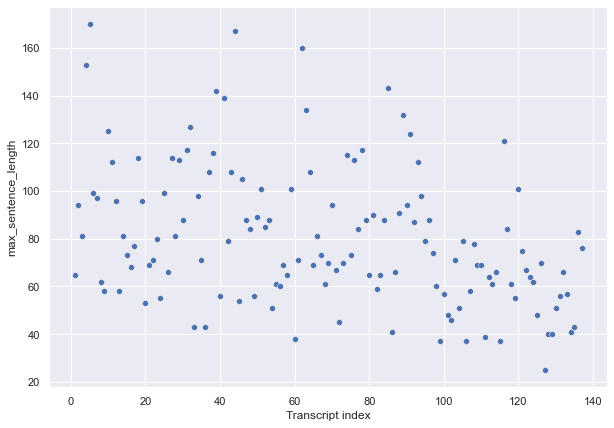

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})
g=sns.scatterplot(x=range(1,len(df['max_sentence_length'])+1),y=df.max_sentence_length)
g.set(xlabel='Transcript index')

### Correlation between maximum sentence length and position. 

Pearson's correlation:  -0.04295678004026573
p-value:  0.6181884235380323


<AxesSubplot:xlabel='max_sentence_position', ylabel='max_sentence_length'>

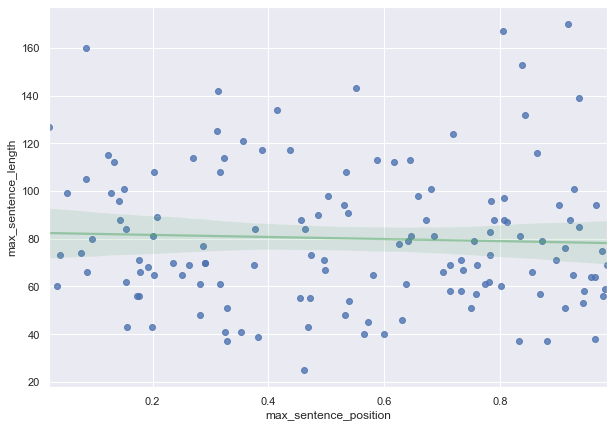

In [ ]:
corr=scipy.stats.pearsonr(df.max_sentence_position, df.max_sentence_length)
print('Pearson\'s correlation: ', corr[0])
print('p-value: ', corr[1])
sns.set(rc={'figure.figsize':(10,7)})
sns.regplot(x=df.max_sentence_position,y=df.max_sentence_length,line_kws={"color": "g", "alpha":0.5})

The plot below does not show any significant findings

<AxesSubplot:xlabel='min_sentence_position', ylabel='min_sentence_length'>

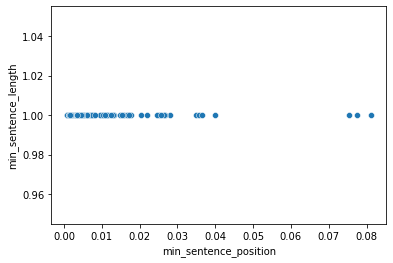

In [ ]:
sns.scatterplot(x=df.min_sentence_position,y=df.min_sentence_length)

### Maximum, minimum sentences, their positions and their length of summaries

In [ ]:
extractive_max_len_list=[]
extractive_min_len_list=[]
extractive_max_sentence=[]
extractive_min_sentence=[]
extractive_max_sentence_position=[]
extractive_min_sentence_position=[]
for sentences in df.extractive_summ_sentence_tokens:
    minimum=min([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    maximum=max([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    extractive_min_sentence.append(sentences[minimum[1]])
    extractive_max_sentence.append(sentences[maximum[1]])
    extractive_min_len_list.append(minimum[0])
    extractive_max_len_list.append(maximum[0])
    extractive_min_sentence_position.append((minimum[1]+1)/len(sentences))
    extractive_max_sentence_position.append((maximum[1]+1)/len(sentences))
df['extractive_max_sentence_length']=extractive_max_len_list
df['extractive_min_sentence_length']=extractive_min_len_list
df['extractive_max_sentence']=extractive_max_sentence
df['extractive_min_sentence']=extractive_min_sentence
df['extractive_max_sentence_position']=extractive_max_sentence_position
df['extractive_min_sentence_position']=extractive_min_sentence_position


abstractive_max_len_list=[]
abstractive_min_len_list=[]
abstractive_max_sentence=[]
abstractive_min_sentence=[]
abstractive_max_sentence_position=[]
abstractive_min_sentence_position=[]

for sentences in df.abstractive_summ_sentence_tokens:
    minimum=min([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    maximum=max([(len(i.split(' ')),index) for index,i in enumerate(sentences)])
    abstractive_min_sentence.append(sentences[minimum[1]])
    abstractive_max_sentence.append(sentences[maximum[1]])
    abstractive_min_len_list.append(minimum[0])
    abstractive_max_len_list.append(maximum[0])
    abstractive_min_sentence_position.append((minimum[1]+1)/len(sentences))
    abstractive_max_sentence_position.append((maximum[1]+1)/len(sentences))
df['abstractive_max_sentence_length']=abstractive_max_len_list
df['abstractive_min_sentence_length']=abstractive_min_len_list
df['abstractive_max_sentence']=abstractive_max_sentence
df['abstractive_min_sentence']=abstractive_min_sentence
df['abstractive_max_sentence_position']=abstractive_max_sentence_position
df['abstractive_min_sentence_position']=abstractive_min_sentence_position
df.head()

,Sentences,abstractive_summary,extractive_summary,sentence_tokens,word_tokens,refined_words,extractive_summ_sentence_tokens,extractive_summ_word_tokens,extractive_summ_refined_words,abstractive_summ_sentence_tokens,...,extractive_max_sentence,extractive_min_sentence,extractive_max_sentence_position,extractive_min_sentence_position,abstractive_max_sentence_length,abstractive_min_sentence_length,abstractive_max_sentence,abstractive_min_sentence,abstractive_max_sentence_position,abstractive_min_sentence_position
ES2002a,Um I'm Craig and I'm User Interface. Yeah. Wel...,The project manager introduced the upcoming pr...,Um well this is the kick-off meeting for our o...,"[Um I'm Craig and I'm User Interface., Yeah., ...","[Um, I, 'm, Craig, and, I, 'm, User, Interface...","[um, 'm, craig, 'm, user, interfac, ., yeah, ....",[Um well this is the kick-off meeting for our ...,"[Um, well, this, is, the, kick-off, meeting, f...","[um, well, kick-off, meet, project, ., 're, de...",[The project manager introduced the upcoming p...,...,"Um so inbetween now and then , um as the indus...",Um.,0.902439,0.365854,35,11,The project manager introduced the upcoming pr...,The project manager talked about the project f...,0.333333,0.666667
ES2002b,"Mm yeah. Nope, we're all set. Which which is t...",The project manager briefed the team on some n...,"Okay , we've got half an hour for this one um ...","[Mm yeah., Nope, we're all set., Which which i...","[Mm, yeah, ., Nope, ,, we, 're, all, set, ., W...","[mm, yeah, ., nope, ,, 're, set, ., clunki, on...","[Okay , we've got half an hour for this one um...","[Okay, ,, we, 've, got, half, an, hour, for, t...","[okay, ,, 've, got, half, hour, one, um, uh, d...",[The project manager briefed the team on some ...,...,Well well a worry that was was expressed in th...,.,0.783217,0.216783,27,16,The marketing expert presented consumer prefer...,The project manager briefed the team on some n...,0.666667,0.166667
ES2002c,"Yeah. Yeah, sure. It kinda does make sense, do...",The project manager recapped the decisions mad...,I'll just just recap on the minutes from the l...,"[Yeah., Yeah, sure., It kinda does make sense,...","[Yeah, ., Yeah, ,, sure, ., It, kinda, does, m...","[yeah, ., yeah, ,, sure, ., kinda, make, sens,...",[I'll just just recap on the minutes from the ...,"[I, 'll, just, just, recap, on, the, minutes, ...","['ll, recap, minut, last, meet, ., decid, targ...",[The project manager recapped the decisions ma...,...,So my my feeling is that we w do want to obser...,Feel like fruit.,0.106383,1.000000,41,11,The marketing expert discussed his findings fr...,The project manager recapped the decisions mad...,0.333333,0.166667
ES2002d,"No. Ninja Homer, made in Japan. And there isn'...",The project manager recapped the decisions mad...,Well this is the uh final detailed design meet...,"[No., Ninja Homer, made in Japan., And there i...","[No, ., Ninja, Homer, ,, made, in, Japan, ., A...","[., ninja, homer, ,, made, japan, ., n't, uh, ...",[Well this is the uh final detailed design mee...,"[Well, this, is, the, uh, final, detailed, des...","[well, uh, final, detail, design, meet, ., um,...",[The project manager recapped the decisions ma...,...,"I mean sort of taking upon that idea , w the w...",No.,0.859813,0.280374,34,8,The team felt that their creativity was hinder...,The prototype did fairly well in the evaluation.,1.000000,0.714286
ES2003a,"Okay, well I think we're ready to begin. Right...",The team members introduced themselves to each...,"my name's Adam Duguid , Ebenezer Ademesoye . I...","[Okay, well I think we're ready to begin., Rig...","[Okay, ,, well, I, think, we, 're, ready, to, ...","[okay, ,, well, think, 're, readi, begin, ., r...","[my name's Adam Duguid , Ebenezer Ademesoye., ...","[my, name, 's, Adam, Duguid, ,, Ebenezer, Adem...","[name, 's, adam, duguid, ,, ebenez, ademesoy, ...",[The team members introduced themselves to eac...,...,Would the the idea something along the lines o...,T_A_R_I_K_.,

### Correlation between maximum sentence lengths of transcripts and their extractive summaries

Pearson's correlation:  0.6871171060360095
p-value:  1.845177340532035e-20


<AxesSubplot:xlabel='extractive_max_sentence_length', ylabel='max_sentence_length'>

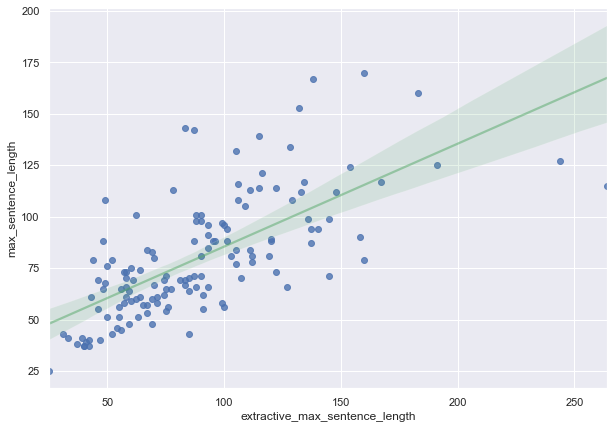

In [ ]:
corr=scipy.stats.pearsonr(df.extractive_max_sentence_length, df.max_sentence_length)
print('Pearson\'s correlation: ', corr[0])
print('p-value: ', corr[1])
sns.set(rc={'figure.figsize':(10,7)})
sns.regplot(x=df.extractive_max_sentence_length, y=df.max_sentence_length,line_kws={"color": "g", "alpha":0.5})

### Correlation between maximum sentence lengths of transcripts and their abstractive summaries 

Pearson's correlation:  -0.01026570848272784
p-value:  0.9052284415302891


<AxesSubplot:xlabel='abstractive_max_sentence_length', ylabel='max_sentence_length'>

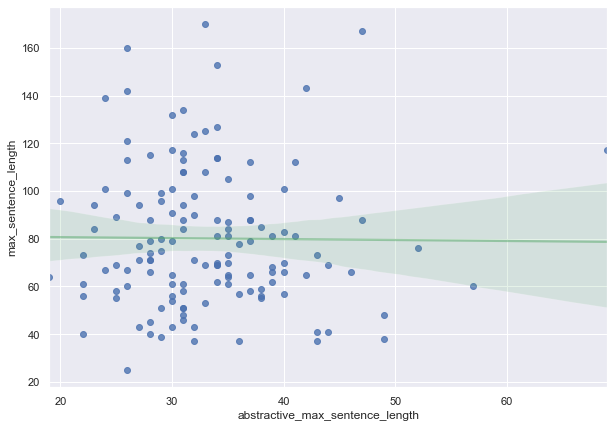

In [ ]:
corr=scipy.stats.pearsonr(df.abstractive_max_sentence_length, df.max_sentence_length)
print('Pearson\'s correlation: ', corr[0])
print('p-value: ', corr[1])
sns.set(rc={'figure.figsize':(10,7)})
sns.regplot(x=df.abstractive_max_sentence_length, y=df.max_sentence_length, line_kws={"color": "g", "alpha":0.5})

### Median and Mean of the positionof sentences taken in the extractive summaries 

In [ ]:
medians=[]
position_indices=[]
for index,extractive_sentences in enumerate(df.extractive_summ_sentence_tokens):
    indices=[]
    for sent in extractive_sentences:
        if sent in df['sentence_tokens'].iloc[index]:
            indices.append((df['sentence_tokens'].iloc[index].index(sent)+1)/len(df['sentence_tokens'].iloc[index]))
    medians.append(median(indices))
    position_indices.append(indices)
df['medians']=medians

Q3 =  [0.55645161]
Q1 =  [0.37108434]


<AxesSubplot:ylabel='medians'>

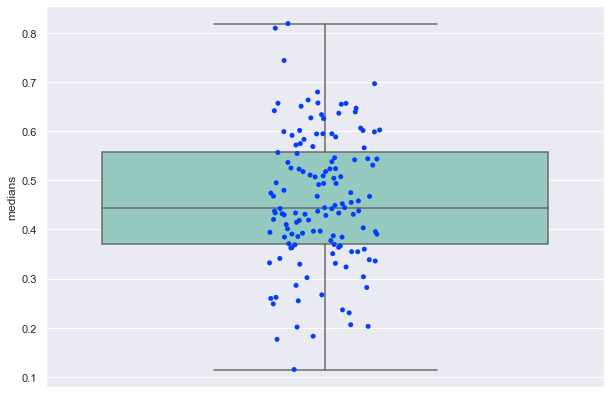

In [ ]:
print('Q3 = ',np.percentile(df['medians'], [75]))
print('Q1 = ',np.percentile(df['medians'], [25]))
sns.set(rc={'figure.figsize':(10,7)})
sns.boxplot(y=df.medians, palette='Set3')
sns.stripplot(y=df.medians,palette='bright')

In [ ]:
means=[sum(i)/len(i) for i in position_indices]
df['means']=means

Q3 =  [0.52352682]
Q1 =  [0.40696165]


<AxesSubplot:ylabel='means'>

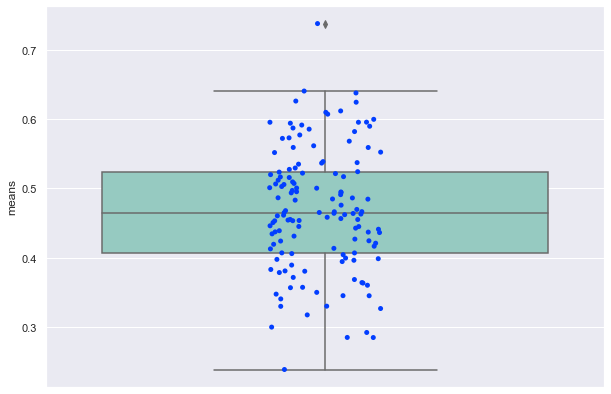

In [ ]:
print('Q3 = ',np.percentile(df['means'], [75]))
print('Q1 = ',np.percentile(df['means'], [25]))
sns.set(rc={'figure.figsize':(10,7)})
sns.boxplot(y=df.means, palette='Set3')
sns.stripplot(y=df.means,palette='bright')

### Agreed words and their relation to important sentences 

In [ ]:
agreed_words_list=[]
yea_list=['ok', 'yes', 'ye', 'yeah', 'yea', 'okay', 'k']
for index in range(len(df.sentence_tokens)):
    yea_bool=[]
    for sentence in df.sentence_tokens.iloc[index]:
        for word in yea_list:
            if word in sentence:
                yea_bool.append(1)
                break
            elif word=='k':
                yea_bool.append(0)
    agreed_words_list.append(yea_bool)

In [ ]:
temp=[]
for index,j in enumerate(agreed_words_list):
    check=[]
    for i in range(0,len(j),4):
        if sum(j[i:i+4])>=2:
            check.append(df.sentence_tokens.iloc[index][i-2:i+2])
    check=sum(check,[])
    temp.append(check)

In [ ]:
percent=[]
for index in range(len(df.extractive_summ_sentence_tokens)):
    summ=0
    for i in df.extractive_summ_sentence_tokens.iloc[index]:
        if i in temp[index]:
            summ+=1
    percent.append(summ/len(df.extractive_summ_sentence_tokens.iloc[index]))
df['percent_agreed_words_exp']=percent

In [ ]:
# this is the percent of sentences found in the extractive summary based on affirmations

df.percent_agreed_words_exp

ES2002a    0.219512
ES2002b    0.118881
ES2002c    0.148936
ES2002d    0.186916
ES2003a    0.085714
             ...   
TS3011c    0.234234
TS3011d    0.240506
TS3012a    0.125000
TS3012b    0.131313
TS3012d    0.166667
Name: percent_agreed_words_exp, Length: 137, dtype: float64

In [ ]:
# Average of percent
df.percent_agreed_words_exp.sum()/len(df.percent_agreed_words_exp)

0.1739709237358732

<AxesSubplot:ylabel='percent_agreed_words_exp'>

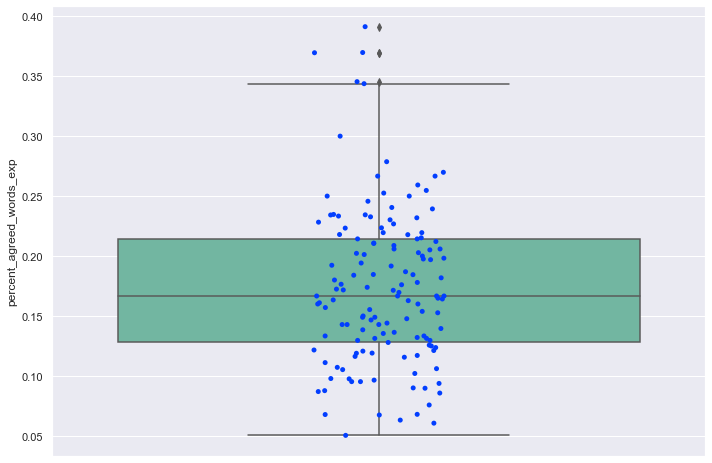

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=df.percent_agreed_words_exp, palette='Set2')
sns.stripplot(y=df.percent_agreed_words_exp, palette='bright' )

In [ ]:
#df.to_excel('ami_corpus_exploration_data.xlsx')